## Problem 1

First we are going to run the fit for the original set or parameters and compare that with running it with the updated ones.

2507 2507
chisq is  15267.937968222595  for  2501  degrees of freedom.


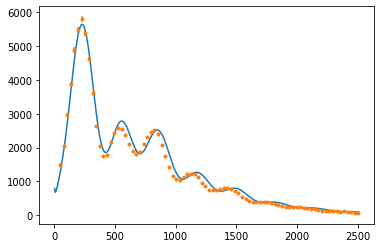

In [266]:

import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


plt.ion()

pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
print(len(ell), len(spec))

errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()


(2507,)
chisq is  3272.2033778089576  for  2501  degrees of freedom.


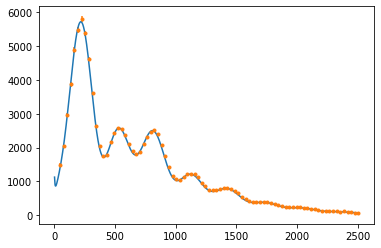

In [190]:

import numpy as np
import camb
from matplotlib import pyplot as plt
import time


def get_spectrum(pars,lmax=3000):
    #print('pars are ',pars)
    H0=pars[0]
    ombh2=pars[1]
    omch2=pars[2]
    tau=pars[3]
    As=pars[4]
    ns=pars[5]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt[2:]


plt.ion()

pars=np.asarray([69,0.022,0.12,0.06,2.10e-9,0.95])
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3]);
model=get_spectrum(pars)
model=model[:len(spec)]
resid=spec-model
print(spec.shape)
chisq=np.sum( (resid/errs)**2)
print("chisq is ",chisq," for ",len(resid)-len(pars)," degrees of freedom.")
#read in a binned version of the Planck PS for plotting purposes
planck_binned=np.loadtxt('COM_PowerSpect_CMB-TT-binned_R3.01.txt',skiprows=1)
errs_binned=0.5*(planck_binned[:,2]+planck_binned[:,3]);
plt.clf()
plt.plot(ell,model)
plt.errorbar(planck_binned[:,0],planck_binned[:,1],errs_binned,fmt='.')
plt.show()



We can see by eye and by looking at the chi squared value that the second set of parameters is a much more appropriate fit. However it is also important to know if each of the fits is approriate not just which one is better. Since the distribution of the $\chi^2$ has high degrees of freedom it can be approximated as a normal ditribution which has a mean of $2501$ and a $\sigma$ of $\sqrt{2*2501} = 71$ The first fit is 180$\sigma$ off from the mean and the second is about 11 $\sigma$. So the first one is not very acceptable and the second one is. 



## Problem 2

Here we will set up Newton's Method to do a fit. The first step is to determine the gradient of the model which means we need to take a derivative with respect to each parameter while keeping the others constant. 

In [211]:
#%# calculate matrices for componenets of derivative, only one parameter changing 

def deriv_mat(parm,dx_mult=0.01):
    dx = dx_mult*parm 

    parm_ranges = np.empty((len(parm),len(parm)))
    for i in range(6):
        parm_ranges[i,:] = parm 
    
    parm_high = np.copy(parm_ranges)
    for i in range(6):
        parm_high[i,i] = (parm[i] * dx_mult)+ parm[i]

    parm_low = np.copy(parm_ranges)
    for i in range(6):
        parm_low[i,i] = parm[i] - (parm[i] * dx_mult)
    
    return parm_ranges, dx, parm_high,parm_low


In [239]:
#%# define the derivative 

def d(func, dx,x_high,x_low):
    return (func(x_high) - func(x_low))/(2*dx)

def ndiff(fun , x,dx,x_high,x_low, full=False):
    df = d(fun, dx,x_high,x_low)
    
    return df

In [213]:

#create the derivative matrix wrt each parameter 
#final shape of the deriv matrix will be (3049,6) each column is one parameter

def take_deriv(parm_ranges,func):
    model_out = func(parm_ranges)
    parm_ranges, dx, parm_high,parm_low = deriv_mat(parm_ranges)
    deriv = np.empty((3049,dx.shape[0]))
    for i in range(dx.shape[0]):
        deriv[:,i] = ndiff(get_spectrum,parm_ranges[i,:],dx[i],parm_high[i,:], parm_low[i,:])
    return model_out, deriv 

In [271]:
import csv

## 2 Linear algenbra for newton's method

#calculate the model A(m0) and the local gradient Am
#m0 is the initial guess on the parameters 
#set N inverse to 1 
#solve for delta m in the linear system

planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

def fit_newton(param,fun,y,niter=4):
    
    chisq_save =[]
    param_save = []
    err_save =[]
    
    
    for i in range(niter):
        
        for i in range(len(param)): 
            if param[i] < 0: 
                print('Force parameters to be positive')
                param[i] = np.abs(param[i])
                
        print('')
        print('Starting parameters', param)
        param_start  = np.copy(param)
        A_m0, Am_grad = take_deriv(param, fun)
        A_m0 = A_m0[:len(y)] ; Am_grad = Am_grad[:len(y)]
        r = y - A_m0
        rhs = Am_grad.T@r
        lhs = Am_grad.T@Am_grad
        delta_m = np.linalg.inv(lhs) @ (rhs)
        param_try = delta_m + param
        chisq = np.sum((r/errs)**2)
        
        curv_matrix = lhs 
        cov_matrix = np.linalg.inv(curv_matrix)
        
        chisq_save.append(chisq)
        param_save.append(param)
        err_save.append(np.sqrt(np.diagonal(cov_matrix)))
        

        A_m = fun(param_try)
        r = y - A_m[:len(y)]
        chisq_new = np.sum((r/errs)**2)
    

        if chisq_new < chisq: 
            param = param_try
            print('New chisq {} smaller than previous {}; updating parameters'.format(chisq_new,chisq))
        else: 
            param = param - delta_m 
            print('New chisq {} larger than previous {}; use old parameters try new direction'.format(chisq_new,chisq))

    file = open('planck_fit_params.txt', "w")
    writer = csv.writer(file)
    for i in range(len(chisq_save)):
        writer.writerow([chisq_save[i], param_save[i], err_save[i]])
        
    print('saving curve matrix for chisq',chisq )
    return param_start,cov_matrix
    
#curvature matrix = 2*inv(lhs)


param_mcmc, cov_mat_mcmc = fit_newton(np.asarray([60.0,0.02,0.1,0.05,2.00e-9,1.0]),get_spectrum, spec)



Starting parameters [6.e+01 2.e-02 1.e-01 5.e-02 2.e-09 1.e+00]
New chisq 2998.6258391710453 smaller than previous 15267.937968222595; updating parameters

Starting parameters [6.22308858e+01 2.12728376e-02 1.22479200e-01 4.58951375e-02
 2.06506424e-09 9.36896036e-01]
New chisq 4043.397752975892 larger than previous 2998.6258391710453; use old parameters try new direction

Starting parameters [5.70914961e+01 2.03387289e-02 1.26201993e-01 1.12183829e-01
 2.34735690e-09 9.10210061e-01]
New chisq 2654.3067588598797 smaller than previous 4152.958227542054; updating parameters

Starting parameters [6.68836389e+01 2.21189737e-02 1.19209857e-01 4.46743172e-02
 2.03408588e-09 9.61417302e-01]
New chisq 6597.031936356224 larger than previous 2654.3067588598797; use old parameters try new direction
saving curve matrix for chisq 2654.3067588598797


For Netwon's method it reaches its lowest chisq 4 iterations in. The more iterations the chi squared eventually gets large again and is unable to find another minima as small. 

## Problem 3

Instead of Newton's method, will now try to us MCMC which should do a better job at finding the best fit parameters by finding the global minima for the chisquared instead of a local minima. 

In [299]:
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

#%# get the best fit parameters and covariance matrix from Newton's method
initial_p = param_mcmc
cov = cov_mat_mcmc


#%# Function to calculate the chisq
def calc_chisq(param,y, noise):
    
    model=get_spectrum(param)[:len(y)]
    resid=spec-model
    chisq=np.sum((resid/noise)**2)
    
    return chisq 


def mcmc(param,cov,y,func,nstep=1000,noise=errs):
    pre_chisq = func(param,y,noise)
    npar = len(param)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    for i in range(nstep):
        
        #%# Calculate the step size from the covariance matrix 
        L = np.linalg.cholesky(cov)
        cov_dot = np.dot(L,np.random.randn(npar))
        new_param = param + cov_dot*0.5
        
        #%# make sure that tau is positive 
        if new_param[3] < 0:
            print('WARNING tau is negative, force to be positive')
            new_param[3] = np.abs(new_param[3])
            
        new_chisq = func(new_param,y,noise)
        delta_chisq=new_chisq-pre_chisq
        

        accept_prob=np.exp(-0.5*delta_chisq)            
        if accept_prob > np.random.rand(1): 
            param = new_param
            pre_chisq = new_chisq 
        chain[i,:]=param
        chivec[i]=pre_chisq
    return chain,chivec
    

chain,chivec = mcmc(initial_p,cov,spec,calc_chisq)



Now that we have run the chain we can look at the results to see if there is convergence. Taking a look at the chi squared values we can it reducing with the number of iterations. We can also look at the Fourier transform of the chains for each parameter over the iterations. Since these are eventually flattening out we can be fairly confident in our convergence.

In [312]:
print('chain:',chain) 
print('chai size', chain.shape)

print('chain:',chivec) 
print('chai size', chivec.shape)

chain: [[6.68853431e+01 2.21198578e-02 1.19211977e-01 4.47928923e-02
  2.03459957e-09 9.61428616e-01]
 [6.68892060e+01 2.21200421e-02 1.19203713e-01 4.48150903e-02
  2.03465183e-09 9.61452208e-01]
 [6.68881472e+01 2.21208240e-02 1.19205010e-01 4.47163673e-02
  2.03424931e-09 9.61450752e-01]
 ...
 [6.70633844e+01 2.21603658e-02 1.18892997e-01 5.38812443e-02
  2.07023141e-09 9.62809502e-01]
 [6.70590732e+01 2.21589896e-02 1.18898383e-01 5.37642182e-02
  2.06980117e-09 9.62795118e-01]
 [6.70592051e+01 2.21603414e-02 1.18898958e-01 5.36883476e-02
  2.06949388e-09 9.62802151e-01]]
chai size (1000, 6)
chain: [2654.11687737 2654.07012674 2654.08307471 2654.22301242 2654.29714038
 2654.43725115 2654.37415463 2654.74805462 2654.74805462 2654.83150792
 2654.68705151 2654.57854095 2654.51478089 2654.46525146 2654.76839953
 2654.96490156 2655.10606438 2654.93768427 2654.74583711 2654.9215888
 2654.85555351 2654.90305575 2655.05765575 2654.97922475 2655.19893109
 2655.32445738 2655.44857624 2655.70

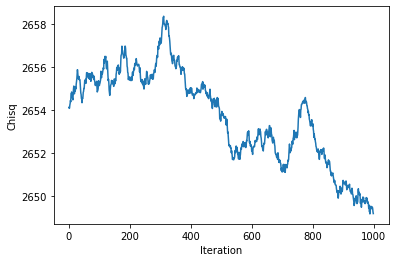

In [300]:
plt.plot(range(chivec.shape[0]),chivec)
plt.xlabel('Iteration')
plt.ylabel('Chisq')
plt.show()

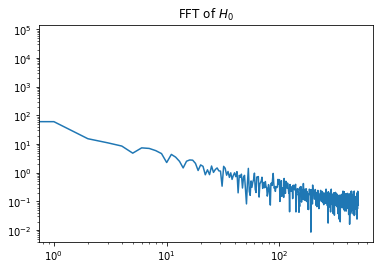

In [304]:
chainfft_h0 = np.fft.rfft(chain[:,0])
plt.loglog(np.abs(chainfft_h0)) 
plt.title('FFT of $H_0$')
plt.show()

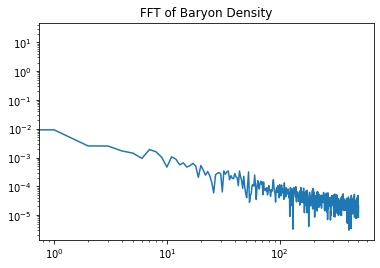

In [305]:
chainfft_ob = np.fft.rfft(chain[:,1])
plt.loglog(np.abs(chainfft_ob)) 
plt.title('FFT of Baryon Density')
plt.show()

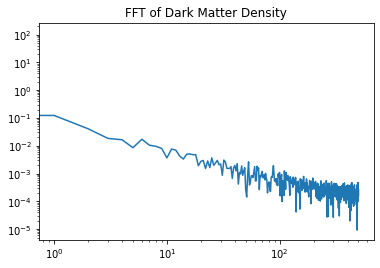

In [306]:
chainfft_oc = np.fft.rfft(chain[:,2])
plt.loglog(np.abs(chainfft_oc)) 
plt.title('FFT of Dark Matter Density')
plt.show()

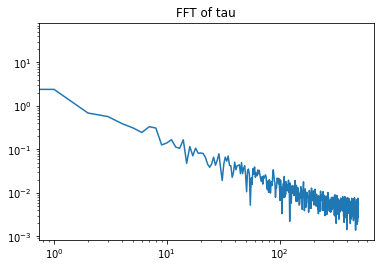

In [308]:
chainfft_tau = np.fft.rfft(chain[:,3])
plt.loglog(np.abs(chainfft_tau)) 
plt.title('FFT of tau')
plt.show()

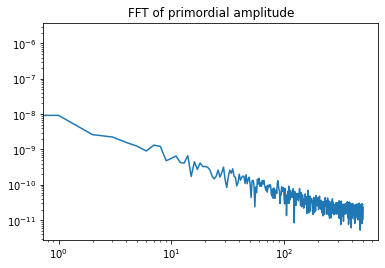

In [309]:
chainfft_A = np.fft.rfft(chain[:,4])
plt.loglog(np.abs(chainfft_A)) 
plt.title('FFT of primordial amplitude')
plt.show()

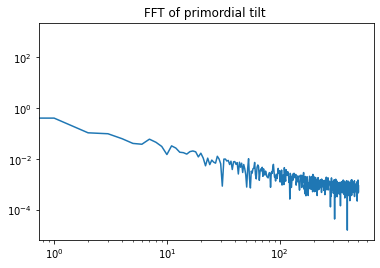

In [310]:
chainfft_n = np.fft.rfft(chain[:,5])
plt.loglog(np.abs(chainfft_n)) 
plt.title('FFT of primordial tilt ')
plt.show()

## Problem 4

Now will rerun the MCMC with a tau prior.

In [317]:
planck=np.loadtxt('COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

#%# get the best fit parameters and covariance matrix from Newton's method
initial_p = param_mcmc
cov = cov_mat_mcmc


#%# Function to calculate the chisq
def calc_chisq(param,y, noise):
    
    model=get_spectrum(param)[:len(y)]
    resid=spec-model
    chisq=np.sum((resid/noise)**2)
    
    return chisq 


def mcmc(param,cov,y,func,nstep=1000,noise=errs):
    #%# set the tau prior
    param[3] = 0.054
    pre_chisq = func(param,y,noise)
    npar = len(param)
    chain=np.zeros([nstep,npar])
    chivec=np.zeros(nstep)
    for i in range(nstep):
        
        #%# Calculate the step size from the covariance matrix 
        L = np.linalg.cholesky(cov)
        cov_dot = np.dot(L,np.random.randn(npar))
        new_param = param + cov_dot*0.5
        
        #%# set the tau prior
        new_param[3] = 0.054
            
        new_chisq = func(new_param,y,noise)
        delta_chisq=new_chisq-pre_chisq
        

        accept_prob=np.exp(-0.5*delta_chisq)            
        if accept_prob > np.random.rand(1): 
            param = new_param
            pre_chisq = new_chisq 
        chain[i,:]=param
        chivec[i]=pre_chisq
    return chain,chivec
    

chain_tau,chivec_tau = mcmc(initial_p,cov,spec,calc_chisq)




In [318]:
print('chain:',chain_tau) 
print('chai size', chain_tau.shape)

print('chain:',chivec_tau) 
print('chai size', chivec_tau.shape)

chain: [[6.68836389e+01 2.21189737e-02 1.19209857e-01 5.40000000e-02
  2.03408588e-09 9.61417302e-01]
 [6.68836389e+01 2.21189737e-02 1.19209857e-01 5.40000000e-02
  2.03408588e-09 9.61417302e-01]
 [6.68836389e+01 2.21189737e-02 1.19209857e-01 5.40000000e-02
  2.03408588e-09 9.61417302e-01]
 ...
 [6.72347652e+01 2.21878949e-02 1.18372202e-01 5.40000000e-02
  2.09022895e-09 9.64067847e-01]
 [6.72259199e+01 2.21859609e-02 1.18386681e-01 5.40000000e-02
  2.08956249e-09 9.64011512e-01]
 [6.72325611e+01 2.21873588e-02 1.18374896e-01 5.40000000e-02
  2.08920740e-09 9.64048432e-01]]
chai size (1000, 6)
chain: [3046.55822136 3046.55822136 3046.55822136 3046.55822136 3046.55822136
 3048.1007086  3034.2016393  3034.2016393  3036.95837857 3036.1979893
 3034.56756464 3034.54509561 3034.54509561 3034.30172726 3027.99835473
 3027.99835473 3022.67106579 3022.67106579 3024.54367999 3016.6461074
 3010.20071288 3007.47880419 3006.21603397 3006.77320088 3010.63509458
 3005.32609589 3005.32609589 2999.012

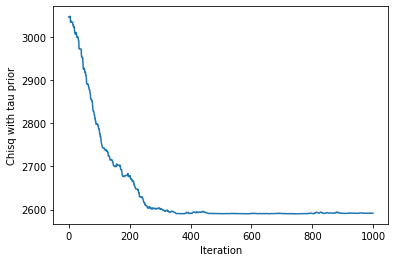

In [319]:
plt.plot(range(chivec_tau.shape[0]),chivec_tau)
plt.xlabel('Iteration')
plt.ylabel('Chisq with tau prior')
plt.show()

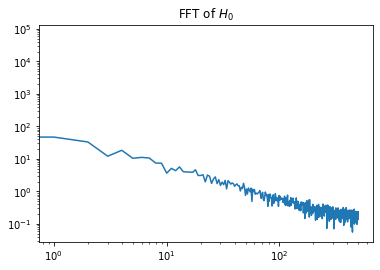

In [320]:
chainfft_h0 = np.fft.rfft(chain_tau[:,0])
plt.loglog(np.abs(chainfft_h0)) 
plt.title('FFT of $H_0$')
plt.show()

The chain does similarly with the tau prior, however it does seem to take a little longer to converge. 